In [3]:
import os 
import torch 
from torch.utils.data import DataLoader, Dataset 
from torchvision import transforms 
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
from torch.optim.lr_scheduler import StepLR 


import shutil 
from sklearn.model_selection import train_test_split 
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 

# Image processing 
import pandas as pd 
import numpy as np 
from PIL import Image 
import cv2 

# Data visualisation 
import matplotlib.pyplot as plt 

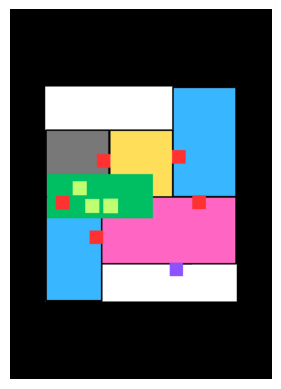

In [4]:
# Function to read images from a folder and store them in a list
def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith('.png'):  # Adjust extensions as needed
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)
            if image is not None:
                images.append(image)
    return images

# Defining the paths 
train_input = r'C:\Users\cecilia\OneDrive\3. SIM-UOL UNI DEGREE\Y3 Sem 2\1. Final year project\4. Coding\cgan\dataset\train\input'
train_target = r'C:\Users\cecilia\OneDrive\3. SIM-UOL UNI DEGREE\Y3 Sem 2\1. Final year project\4. Coding\cgan\dataset\train\target'
val_input = r'C:\Users\cecilia\OneDrive\3. SIM-UOL UNI DEGREE\Y3 Sem 2\1. Final year project\4. Coding\cgan\dataset\val\input'
val_target = r'C:\Users\cecilia\OneDrive\3. SIM-UOL UNI DEGREE\Y3 Sem 2\1. Final year project\4. Coding\cgan\dataset\val\target'
test_input = r'C:\Users\cecilia\OneDrive\3. SIM-UOL UNI DEGREE\Y3 Sem 2\1. Final year project\4. Coding\cgan\dataset\test\input'
test_target = r'C:\Users\cecilia\OneDrive\3. SIM-UOL UNI DEGREE\Y3 Sem 2\1. Final year project\4. Coding\cgan\dataset\test\target'

# Load images from each folder
train_input_images = load_images_from_folder(train_input)
train_target_images = load_images_from_folder(train_target)
val_input_images = load_images_from_folder(val_input)
val_target_images = load_images_from_folder(val_target)
test_input_images = load_images_from_folder(test_input)
test_target_images = load_images_from_folder(test_target)

# Display the first image from train_input as an example (convert BGR to RGB for proper display)
if train_input_images:
    plt.imshow(cv2.cvtColor(train_target_images[0], cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Hide axes
    plt.show()
else:
    print("No images found in the train input folder.")
    

In [5]:
# Custom Dataset Class
class PairedImageDataset(Dataset):
    def __init__(self, input_dir, target_dir, transform=None):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.transform = transform
        self.input_images = sorted(os.listdir(self.input_dir))
        self.target_images = sorted(os.listdir(self.target_dir))

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        input_image_path = os.path.join(self.input_dir, self.input_images[idx])
        target_image_path = os.path.join(self.target_dir, self.target_images[idx])

        input_image = Image.open(input_image_path).convert('RGB')
        target_image = Image.open(target_image_path).convert('RGB')

        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)

        return input_image, target_image

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Load dataset
train_dataset = PairedImageDataset(
    input_dir=train_input,
    target_dir=train_target,
    transform=transform
)
val_dataset = PairedImageDataset(
    input_dir=val_input,
    target_dir=val_target,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # 8
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [6]:

# Define Encoder with corrected linear layer sizes
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
        )

        # Example input size
        self.example_input = torch.randn(1, 3, 256, 256)
        self._initialize()

    def _initialize(self):
        with torch.no_grad():
            x = self.example_input
            x = self.model(x)  # Forward pass to get output shape
            self.flattened_size = x.view(-1).size(0)
            self.fc_mu = nn.Linear(self.flattened_size, 128)
            self.fc_logvar = nn.Linear(self.flattened_size, 128)

    def forward(self, x):
        x = self.model(x)  # Use self.model for forward pass
        # print("Shape after conv layers:", x.shape)  # Print shape to verify dimensions
        x = x.view(x.size(0), -1)  # Flatten
        # print("Shape after flattening:", x.shape)  # Print shape to verify dimensions
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

# Define Generator and Discriminator classes
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # Output: [64, 128, 128]
            nn.ReLU(True),
            nn.Dropout(0.5), # only have one dropout layer 
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # Output: [128, 64, 64]
            nn.ReLU(True), 
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # Output: [256, 32, 32]
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # Output: [512, 16, 16]
            nn.ReLU(True),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),  # Output: [256, 32, 32]
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Output: [128, 64, 64]
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Output: [64, 128, 128]
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),  # Output: [3, 256, 256]
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        final_output = self.decoder(x)
        return final_output


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(64, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Define BicycleGAN model
class BicycleGAN(nn.Module):
    def __init__(self):
        super(BicycleGAN, self).__init__()
        self.generator = Generator()
        self.encoder = Encoder()
        self.discriminator = Discriminator()

    def forward(self, x):
        generated_images = self.generator(x)
        mu, logvar = self.encoder(generated_images)
        return generated_images, mu, logvar

# Instantiate model and check shapes
with torch.no_grad():
    model = BicycleGAN()
    example_input = torch.randn(1, 3, 256, 256)
    
    # Pass through encoder
    encoder = Encoder()
    output = encoder(example_input)
    
    # Check flattened size
    print(f'Flattened size: {encoder.flattened_size}')

    # Check output shape from model
    generated_images, mu, logvar = model(example_input)
    print(f'Output shape from Generator: {generated_images.shape}')
    print(f'Mu shape: {mu.shape}')
    print(f'Logvar shape: {logvar.shape}')


# Instantiate model
model = BicycleGAN()

# Before Flattening
# print(f'Output shape before flattening: {x.shape}')

# After Flattening
# print(f'Flattened size: {x.view(x.size(0), -1).shape}')


Flattened size: 131072
Output shape from Generator: torch.Size([1, 3, 256, 256])
Mu shape: torch.Size([1, 128])
Logvar shape: torch.Size([1, 128])


In [7]:

# Define Loss Functions and Optimizer
criterion_gan = nn.BCELoss()  # Example placeholder for GAN loss
criterion_l1 = nn.L1Loss()  # Example placeholder for L1 loss

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.5, 0.999), weight_decay=1e-5) # lr=0.0002, can change the weight decay 

# Learning Rate Scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# Training Functions
def gan_loss(prediction, target_is_real):
    # prediction = torch.clamp(prediction, 0, 1)
    target = torch.ones_like(prediction) if target_is_real else torch.zeros_like(prediction)
    loss = nn.BCELoss()(prediction, target)  #need to be between 0 and 1, representing 
    return loss

def l1_loss(generated_image, target_image):
    loss = nn.L1Loss()(generated_image, target_image)
    return loss

def kl_loss(mu, logvar):
    loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return loss

In [8]:
# Define validate_model function
def validate_model(model, val_loader, criterion_gan, criterion_l1, lambda_l1, lambda_kl):
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0.0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            generated_images, mu, logvar = model(inputs)
            loss_gan = gan_loss(model.discriminator(generated_images), target_is_real=True)
            loss_l1 = l1_loss(generated_images, targets)
            loss_kl = kl_loss(mu, logvar)
            total_loss = lambda_l1 * loss_l1 + lambda_kl * loss_kl + loss_gan
            total_val_loss += total_loss.item() * inputs.size(0)  # Accumulate loss for the batch
    
    average_val_loss = total_val_loss / len(val_loader.dataset)
    return average_val_loss

# Hyperparameters
lambda_l1 = 15.0  # Weight for L1 loss
lambda_kl = 0.05  # Weight for KL divergence loss

# Training Loop
num_epochs = 30  # Example number of epochs

best_val_loss = float('inf')
patience = 5  # Number of epochs to wait for improvement
counter = 0

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    total_train_loss = 0.0
    for inputs, targets in train_loader:
        # Forward pass
        generated_images, mu, logvar = model(inputs)

        # Compute losses
        loss_gan = gan_loss(model.discriminator(generated_images), target_is_real=True)
        loss_l1 = l1_loss(generated_images, targets)
        loss_kl = kl_loss(mu, logvar)

        # Total loss
        total_loss = lambda_l1 * loss_l1 + lambda_kl * loss_kl + loss_gan

        # Backward pass and optimization
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        total_train_loss += total_loss.item() * inputs.size(0)  # Accumulate loss for the batch

    # Update learning rate
    scheduler.step()

    # Compute average training loss
    average_train_loss = total_train_loss / len(train_loader.dataset)

    # Compute validation loss
    val_loss = validate_model(model, val_loader, criterion_gan, criterion_l1, lambda_l1, lambda_kl)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {average_train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        # Save model checkpoint here
    else:
        counter += 1
    
    if counter >= patience:
        print("Early stopping triggered.")
        break


Epoch [1/30], Train Loss: 5.5177, Val Loss: 4.1856
Epoch [2/30], Train Loss: 4.3666, Val Loss: 4.0642
Epoch [3/30], Train Loss: 4.1828, Val Loss: 4.0061
Epoch [4/30], Train Loss: 4.1619, Val Loss: 3.8933
Epoch [5/30], Train Loss: 3.9934, Val Loss: 3.8103
Epoch [6/30], Train Loss: 3.9122, Val Loss: 3.7074
Epoch [7/30], Train Loss: 3.8306, Val Loss: 3.6703
Epoch [8/30], Train Loss: 3.7760, Val Loss: 3.5998
Epoch [9/30], Train Loss: 3.7647, Val Loss: 3.5856
Epoch [10/30], Train Loss: 3.6932, Val Loss: 3.5363
Epoch [11/30], Train Loss: 3.6471, Val Loss: 3.5293
Epoch [12/30], Train Loss: 3.6405, Val Loss: 3.5211
Epoch [13/30], Train Loss: 3.6327, Val Loss: 3.5129
Epoch [14/30], Train Loss: 3.6252, Val Loss: 3.5051
Epoch [15/30], Train Loss: 3.6179, Val Loss: 3.4970
Epoch [16/30], Train Loss: 3.6103, Val Loss: 3.4881
Epoch [17/30], Train Loss: 3.6023, Val Loss: 3.4791
Epoch [18/30], Train Loss: 3.5937, Val Loss: 3.4705
Epoch [19/30], Train Loss: 3.5856, Val Loss: 3.4640
Epoch [20/30], Train 

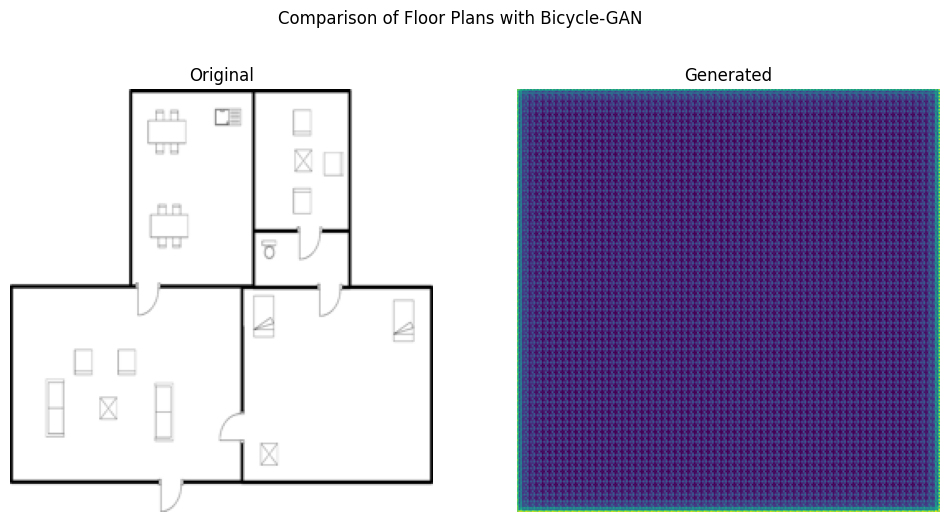

In [9]:
import numpy as np
import torch
from PIL import Image
import matplotlib.pyplot as plt

# Define function to load and preprocess the image
def preprocess_image(image_path):
    image = Image.open(image_path).convert('RGB')
    image = image.resize((256, 256))  # Ensure image size matches network input
    image = torch.tensor(np.array(image), dtype=torch.float32).permute(2, 0, 1).unsqueeze(0) / 255.0
    return image

# Generate images using the trained model
def generate_image(model, input_image):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        generated_images, mu, logvar = model(input_image)  # Unpack the tuple
        generated_image = generated_images[0, 0].numpy()  # Remove batch and channel dimensions
    generated_image = (generated_image * 255).astype(np.uint8)  # Rescale if needed
    return generated_image

# Define paths for your images
input_image_path = r'C:\Users\cecilia\OneDrive\3. SIM-UOL UNI DEGREE\Y3 Sem 2\1. Final year project\4. Coding\cgan\dataset\test\input\Cat45_5.jpg'  # Update with the path to a test image

# Load and preprocess the input image
input_image = preprocess_image(input_image_path)

# Generate an image using the model
generated_image = generate_image(model, input_image)

# Plot the results
def plot_comparison(original, generated, title):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Original')
    plt.imshow(original.permute(1, 2, 0).numpy())  # Convert to HWC format for display
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title('Generated')
    plt.imshow(generated)
    plt.axis('off')
    
    plt.suptitle(title)
    plt.show()

# Plot the results
plot_comparison(input_image.squeeze(), generated_image, 'Comparison of Floor Plans with Bicycle-GAN')


This is the end of the fisrt iteraiton of the first model training. The image is not yet generated well. 